# Dynamic Graph Embeddings for Real-Time Anomaly Detection in Network Traffic

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
import networkx as nx
from node2vec import Node2Vec
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

### Data Acquisition

#### Load the KDD Cup 1999 dataset

In [3]:
gzipped_data = "data/kddcup.data_10_percent.gz"

df = pd.read_csv(gzipped_data, compression='gzip')
df.columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
print('The no of data points are:',df.shape[0])
print('='*40)
print('The no of features are:',df.shape[1])
print('='*40)
print('Some of the features are:',df.columns[:10])

The no of data points are: 494020
The no of features are: 42
Some of the features are: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot'],
      dtype='object')


In [5]:
output = df['label'].values
labels = set(output)
print('The different type of output labels are:',labels)
print('='*125)
print('No. of different output labels are:', len(labels))

The different type of output labels are: {'pod.', 'teardrop.', 'perl.', 'spy.', 'land.', 'imap.', 'back.', 'ipsweep.', 'guess_passwd.', 'buffer_overflow.', 'phf.', 'warezmaster.', 'portsweep.', 'nmap.', 'multihop.', 'rootkit.', 'loadmodule.', 'smurf.', 'normal.', 'ftp_write.', 'neptune.', 'satan.', 'warezclient.'}
No. of different output labels are: 23


### Data Preprocessing

#### Data Cleaning

In [6]:
df.dropna()
df.drop_duplicates()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


#### Exploratory data analysis

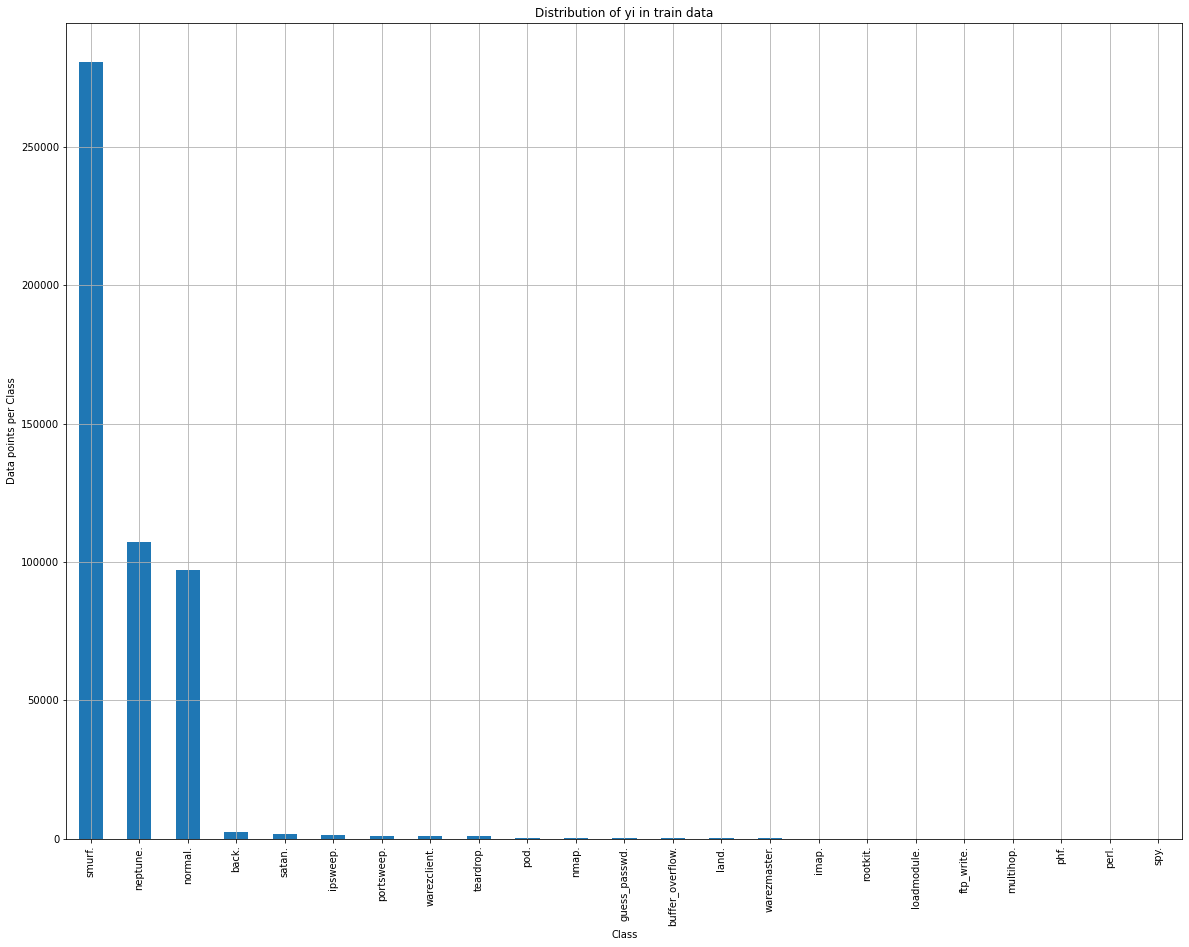

In [7]:
plt.figure(figsize=(20,15))
class_distribution = df['label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'normal.'),
  Text(1, 0, 'buffer_overflow.'),
  Text(2, 0, 'loadmodule.'),
  Text(3, 0, 'perl.'),
  Text(4, 0, 'neptune.'),
  Text(5, 0, 'smurf.'),
  Text(6, 0, 'guess_passwd.'),
  Text(7, 0, 'pod.'),
  Text(8, 0, 'teardrop.'),
  Text(9, 0, 'portsweep.'),
  Text(10, 0, 'ipsweep.'),
  Text(11, 0, 'land.'),
  Text(12, 0, 'ftp_write.'),
  Text(13, 0, 'back.'),
  Text(14, 0, 'imap.'),
  Text(15, 0, 'satan.'),
  Text(16, 0, 'phf.'),
  Text(17, 0, 'nmap.'),
  Text(18, 0, 'multihop.'),
  Text(19, 0, 'warezmaster.'),
  Text(20, 0, 'warezclient.'),
  Text(21, 0, 'spy.'),
  Text(22, 0, 'rootkit.')])

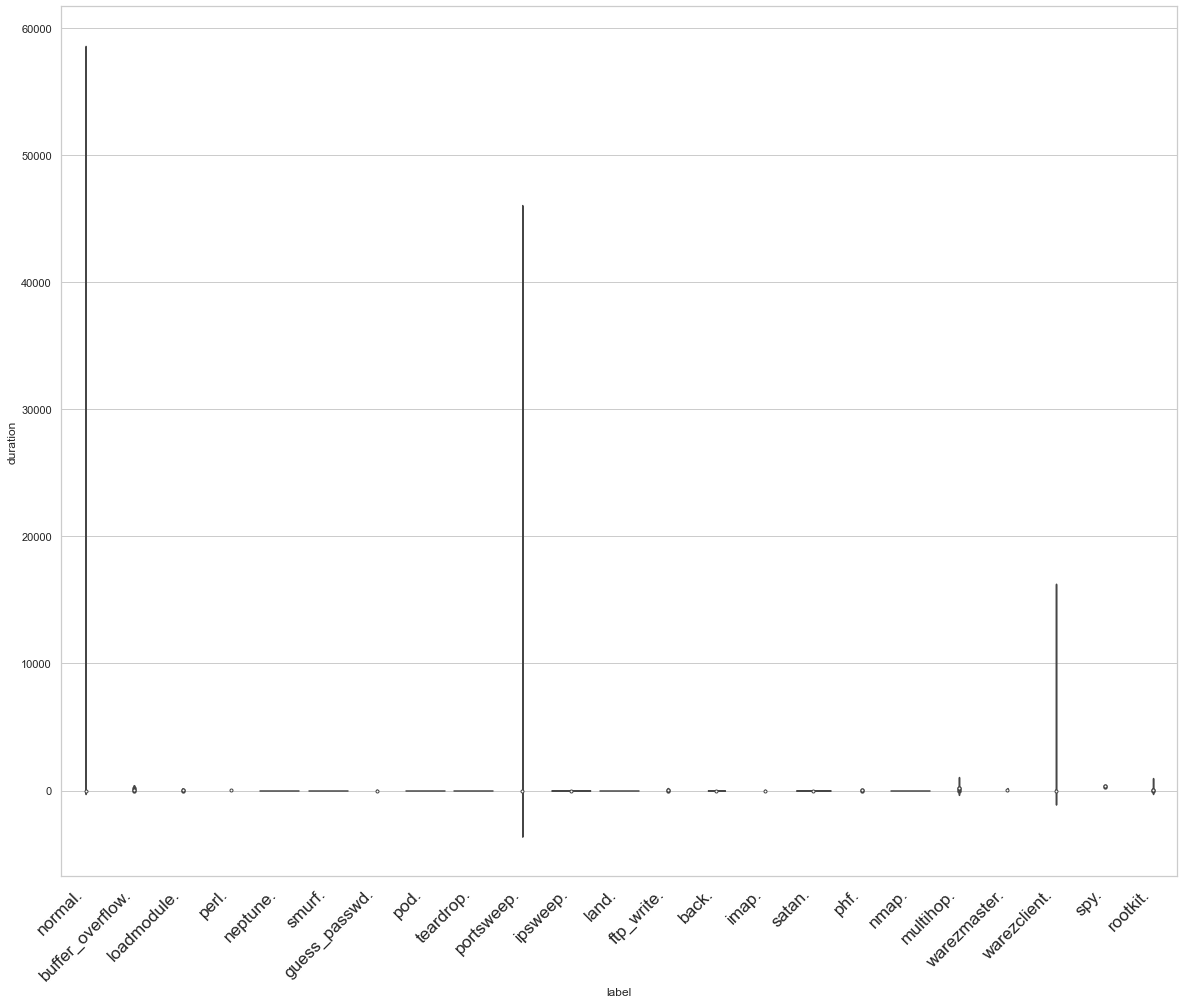

In [7]:
plt.figure(figsize=(20,16))
sns.set(style="whitegrid")
ax = sns.violinplot(x="label", y="duration", data=df, fliersize=None)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

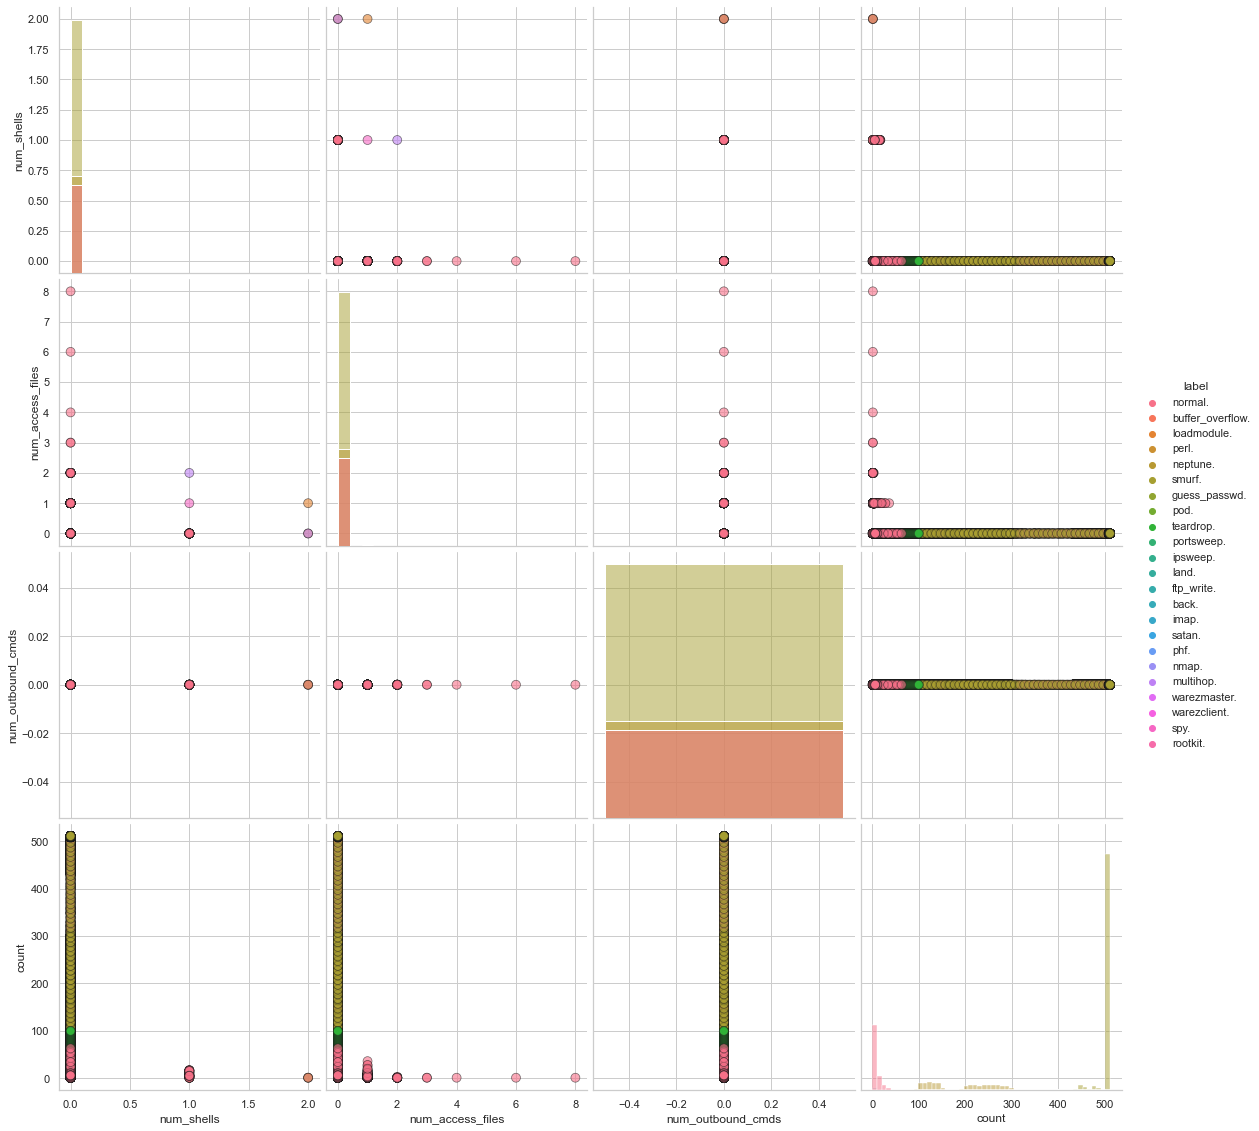

In [27]:
sns.pairplot(df, hue='label', height=4, diag_kind='hist', vars=['num_shells', 'num_access_files', 'num_outbound_cmds', 'count']
             , plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'})

In [8]:
columns_to_keep = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'label'
]
data = df[columns_to_keep]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


#### Encode categorical variables using one-hot encoding

In [9]:
categorical_columns = ['protocol_type', 'service', 'flag']
encoder = LabelEncoder()

data_copy = data.copy()

for col in categorical_columns:
    data_copy[col] = encoder.fit_transform(data_copy[col])


#### Normalize or scale numeric features

In [10]:
numerical_columns = [
    'duration',
    'src_bytes',
    'dst_bytes',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
]

# Create a StandardScaler instance
scaler = StandardScaler()

# Normalize all relevant numerical columns
data_copy[numerical_columns] = scaler.fit_transform(data[numerical_columns])

#### Encode labels as binary (1 for attacks, 0 for normal)

In [11]:
data_copy['target'] = (data['label'] != 'normal.').astype(int)
data_copy.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,count,srv_count,serror_rate,srv_serror_rate,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,label,target
0,-0.067792,1,22,9,-0.002820,-0.011578,-1.521422,-1.156643,-0.46409,-0.463521,...,0.536988,-0.255244,-0.203633,-3.297128,-1.600017,0.599397,-0.282867,-1.146740,normal.,0
1,-0.067792,1,22,9,-0.002824,0.014179,-1.521422,-1.156643,-0.46409,-0.463521,...,0.536988,-0.255244,-0.203633,-3.142675,-1.505713,0.599397,-0.282867,-1.188293,normal.,0
2,-0.067792,1,22,9,-0.002840,0.014179,-1.530805,-1.164762,-0.46409,-0.463521,...,0.536988,-0.255244,-0.203633,-2.988222,-1.411409,0.599397,-0.282867,-1.188293,normal.,0
3,-0.067792,1,22,9,-0.002842,0.035214,-1.530805,-1.164762,-0.46409,-0.463521,...,0.536988,-0.255244,-0.203633,-2.833769,-1.317105,0.599397,-0.282867,-1.209070,normal.,0
4,-0.067792,1,22,9,-0.002842,0.035214,-1.530805,-1.164762,-0.46409,-0.463521,...,0.536988,-0.255244,-0.203633,-2.679316,-1.222802,0.599397,-0.282867,-1.209070,normal.,0


###  Data Splitting

In [12]:
X = data_copy.drop('label', axis=1)
y = data_copy['label']

#### Split the dataset into training, validation and testing sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the training and testing sets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (296412, 21)
Validation data shape: (98804, 21)
Testing data shape: (98804, 21)


In [14]:
def update_graph(dynamic_graph, df):
    # Iterate through the DataFrame rows and add/update nodes and edges
    for _, row in df.iterrows():
        src_ip = row['src_bytes'] 
        dst_ip = row['dst_bytes']  

        # Add nodes if they don't exist
        dynamic_graph.add_node(src_ip)
        dynamic_graph.add_node(dst_ip)

        # Add an edge between source and destination
        dynamic_graph.add_edge(src_ip, dst_ip)

In [17]:
# Create an empty dynamic graph
dynamic_graph = nx.Graph()
update_graph(dynamic_graph, X_train)  

In [ ]:
# Create a Node2Vec instance and generate embeddings
node2vec = Node2Vec(dynamic_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

# Get the embeddings for all nodes in the graph
node_embeddings = {node: model.wv[node] for node in dynamic_graph.nodes()}

Computing transition probabilities: 100%|███████████████████████████████████████| 11406/11406 [00:16<00:00, 694.99it/s]


In [ ]:
# Convert node embeddings to a list
node_embedding_list = list(node_embeddings.values())

# Train the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(node_embedding_list)

# Convert node embeddings to a list
node_embedding_list = [node_embeddings[i] for i in range(len(X_test))]

# Predict anomalies on a test set
predictions = isolation_forest.predict(node_embedding_list)

In [ ]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)